<a href="https://colab.research.google.com/github/al025/Machine-Learning-Study-Notes/blob/master/c1_chap3_fine_tuning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Confusion matrix and classification report
- For a classification task, given **imbalanced** data, 
accuracy metrics (defined as the ratio of correctly classified examples) may not be a good measure of model performance
  - e.g. data: 99% real emails, 1% spam (imbalanced btw classes), classifier: predict all emails as real emails. Then accuracy = 99%, but the classifier completely fails its original purpose
- This is why we need use another metrics: confusion matrix 

\ | pred: spam | pred: real 
---|---------------| -----------
acutal: spam | tp | fn 
actual: real | fp | tn

  - precision = $\frac{tp}{tp+fp}$
  - recall = $\frac{tp}{tp+fn}$
  - f1score = $\frac{2 \cdot precision \cdot recall}{precision + recall}$
  - accuracy = $\frac{tp+tn}{tp+fn+tn+fp}$

In [0]:
# use a imbalanced dataset provided in package imblearn
!pip install -U imbalanced-learn
from imblearn.datasets import fetch_datasets
spectrometer = fetch_datasets()['spectrometer']

In [0]:
from sklearn.model_selection import train_test_split
X, y = spectrometer.data, spectrometer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=25)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
# support = number of true examples of this class

[[196   1]
 [  4  12]]
              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       197
           1       0.92      0.75      0.83        16

    accuracy                           0.98       213
   macro avg       0.95      0.87      0.91       213
weighted avg       0.98      0.98      0.98       213



## ROC curve and logistic regression for *binary* classification
- Logistic regression has a hyperparameter called threshold T, outputs a probability p 
  - if p >= T, this example is labeled 'positive'
  - if p < T, this example is labeled 'negative'
  - so logistic regression has a $linear$ decision boundary 

- ROC (receptive operation characteristic) curve is a binary classifier metrics
  - x-axis: false positive rate (fpr) = $\frac{fp}{fp+tn}$ 
  - y-axis: true positive rate (tpr) = $\frac{tp}{tp+fn}$
  - (0, 1) is perfect classification 
  - ROC curve for random guessing is $y=x$
  - left to $y=x$: better than random guessing 
  - ROC curve is a parameterized curve of thereshold T.
  - as T increases, both fpr and tpr decreases; as T decreases, both fpr
   and tpr increases
  
![An example of ROC curve and how it is related to the data space
 and threshold values](https://commons.wikimedia.org/wiki/File:ROC_curves.svg#/media/File:ROC_curves.svg)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


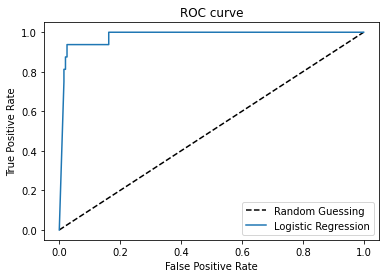

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# predict_proba() returns the predicted probobalities of each class
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [0]:
# area under ROC curve is a good indicator of binary classifier's performance.
# auc > 0.5 better than random guessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

print('AUC score: {}'.format(roc_auc_score(y_test, y_pred_prob)))

# we can also use cross validation to compute AUC score
cv_auc_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
print('AUC scores of 5-fold cross validation: {}'.format(cv_auc_scores))

# Why am I getting the ConvergenceWarning ???

AUC score: 0.9803299492385786
AUC scores of 5-fold cross validation: [1.         0.9683908  0.98275862 1.         0.83333333]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Hyperparameter Tuning by Grid Search and Randomized Search
- hyperparameters cannot be learned by fitting the model
  - e.g. $\alpha$ in lasso/ridge regression, $k$ in KNN, etc.
- so we tune hyperparameters by
  - try a bunch of different hyperparameter values
  - fit a separate model for each of these values
  - choose the best performing one
  - it's essential to use cross validation to avoid overfitting 
- grid search is more comprehensive than randomized search; but also more 
expensive 

- elastic net is a type of linear regression model where its loss function
 is defined as $$loss = \text{sum of squared residuals + l1 norm of coefficients + l2 norm of coefficients}\\
 =\sum_{i=1}^n(y\_pred^{(i)}-y\_true^{(i)})^2 + \gamma\sum_{i=1}^n|a^{(i)}| + (1-\gamma)\gamma\sum_{i=1}^n(a^{(i)})^2
 $$ 
 where $\gamma$ is a hyperparameter called l1 ratio.

- decision tree is a type of tree classification models which has many 
hyperparameters, such as <mark>'max_depth'</mark>,
<mark>'max_features'</mark>,
<mark>'min_samples_leaf'</mark>.



In [0]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import uniform

# to hide all warnings 
import warnings
warnings.filterwarnings('ignore')

elastic_net = ElasticNet()

# the hyperparameter space for a grid search is an array-like object
param_grid = {'l1_ratio': np.linspace(0, 1, 15)}
# the hyperparameter space for a randomized search is a distribution
param_dist = {'l1_ratio': uniform()}

en_gcv = GridSearchCV(elastic_net, param_grid, cv=5)
%timeit en_gcv.fit(X_train, y_train)
print('Tuned l1 ration by grid search: {}'.format(en_gcv.best_params_))
print('Tuned cv score by grid search: {}'.format(en_gcv.best_score_))
y_pred = en_gcv.predict(X_test)
r2 = en_gcv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Tuned R squared by grid search: {}'.format(r2))
print('Tuned MSE by grid search: {}'.format(mse))
# %timeit en_gcv = GridSearchCV(elastic_net, param_grid, cv=5)

en_rcv = RandomizedSearchCV(elastic_net, param_dist, cv=5)
%timeit en_rcv.fit(X_train, y_train)
print('Tuned l1 ration value by randomized search: {}'.format(en_rcv.best_params_))
print('Tuned cv score by randomized search: {}'.format(en_rcv.best_score_))
y_pred = en_rcv.predict(X_test)
r2 = en_rcv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print('Tuned R squared by grid search: {}'.format(r2))
print('Tuned MSE by grid search: {}'.format(mse))
# %timeit en_rcv = RandomizedSearchCV(elastic_net, param_dist, cv=5)

1 loop, best of 3: 2.57 s per loop
Tuned l1 ration by grid search: {'l1_ratio': 1.0}
Tuned cv score by grid search: 0.4473886886267552
Tuned R squared by grid search: 0.288759983309246
Tuned MSE by grid search: 0.2311385043992258
1 loop, best of 3: 1.72 s per loop
Tuned l1 ration value by randomized search: {'l1_ratio': 0.9839022458864596}
Tuned cv score by randomized search: 0.44580883986343967
Tuned R squared by grid search: 0.28777423517525735
Tuned MSE by grid search: 0.23145885244497355


In [0]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

tree = DecisionTreeClassifier()
param_dist = {'max_depth': [3, None],
        'max_features': randint(1, 9),
        'min_samples_leaf': randint(1, 9),
        'criterion': ['entropy', 'gini']}

tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X_train, y_train)

print('Tuned hyperparameters: {}'.format(tree_cv.best_params_))
print('Tuned cv score: {}'.format(tree_cv.best_score_))
y_pred = tree_cv.predict(X_test)
print('Confusion matrix on test set: {}'.format(confusion_matrix(y_test, y_pred)))
print('Classification report on test set: {}'.format(classification_report(y_test, y_pred)))

Tuned hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 7}
Tuned cv score: 0.9716765873015873
Confusion matrix on test set: [[193   1]
 [  5  14]]
Classification report on test set:               precision    recall  f1-score   support

          -1       0.97      0.99      0.98       194
           1       0.93      0.74      0.82        19

    accuracy                           0.97       213
   macro avg       0.95      0.87      0.90       213
weighted avg       0.97      0.97      0.97       213

